1. Policy evaluation
2. Policy iteration
3. Value iteration
4. Monte Carlo prediction
5. Monte Carlo control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [2]:
from gridworld import GridworldEnv
env = GridworldEnv()

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [3]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [4]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in env.P:
            v = V[s]     
            r = np.array([env.P[s][a][0][2] for a in env.P[s]])
            s_prime = np.array([env.P[s][a][0][1] for a in env.P[s]])
            V[s] = policy[s] @ (r + discount_factor * V[s_prime])
            
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return np.array(V)

In [5]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

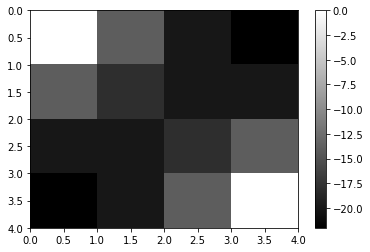

In [6]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

plot_gridworld_value(V.reshape(env.shape))

In [7]:
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [8]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        pol_stable = True
        for s in env.P:
            old_a = policy[s]
            r = np.array([env.P[s][a][0][2] for a in env.P[s]])
            s_prime = np.array([env.P[s][a][0][1] for a in env.P[s]])
            action_value = r + discount_factor * V[s_prime]
            policy[s] = 0
            policy[s][np.argmax(action_value)] = 1
            if np.array_equal(old_a, policy[s]) == False:
                pol_stable = False
        if pol_stable == True:
            V = policy_eval(policy, env, discount_factor) # To see the final value function
            break
        
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<<
^^<v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



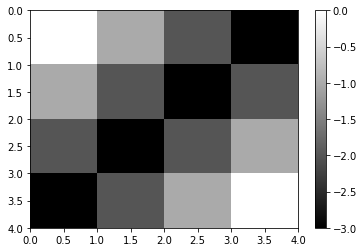

In [9]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [10]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])

    while True:
        delta = 0
        for s in env.P:
            v = V[s]
            r = np.array([env.P[s][a][0][2] for a in env.P[s]])
            s_prime = np.array([env.P[s][a][0][1] for a in env.P[s]])
            values = r + discount_factor * V[s_prime]
            V[s] = np.max(values)
            delta = max(delta, abs(v-V[s]))
        if delta < theta:
            break
    
    for s in env.P:
        r = np.array([env.P[s][a][0][2] for a in env.P[s]])
        s_prime = np.array([env.P[s][a][0][1] for a in env.P[s]])
        action_value = r + discount_factor * V[s_prime]
        policy[s] = 0
        policy[s][np.argmax(values)] = 1
    
    return policy, V

In [11]:
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
^^^^
^^^^
^^^^
^^^^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Policy iteration first estimate $v$ given $\pi$, then updates $\pi$ with the maximum value of $v$ using a greedy approach. Then again estimating $v$ using the new $\pi$ until the policy doesn't change anymore.

Value iteration on the other hand updates $v$ given the max value over all the possible actions. This can be seen as implicitly doing a policy improvement step, since your policy would also be updated given the max value over all the possible actions. 
In this way you don't need to wait for convergence but can already directly work with a better implicit policy.
This approach reduces the amount of backup operations needed and is more efficient than policy iteration.

Note that the obtained value function doesn't belong to any particular policy, therefore the wording implicit policy. 

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

Monte Carlo samples sequence of states until a terminal state is reached and then updates the value function of the visited states. Whereas Dynamic Programming updates all the states Monte Carlo only samples the states. 
Also an MC update exist of completing a whole episode, whereas the DP algorithm updates after each step.

Because MC samples, it doesn't require the whole MDP and the environment's dynamics $p$.
MC is preffered over DP if
1. DP becomes too computational expensive or
2. The dynamics of the environment and thus the MDP is not known (in this case DP is not possible at all)

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [12]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [13]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [14]:
# We can also look at the documentation/implementation of a method
?env.step

In [15]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [16]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score = observation[0]
    if score >= 20:
        return 0
    else:
        return 1

In [17]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(21, 10, True)
((21, 10, True), 0, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [18]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)

    states = []
    for i in range(num_episodes):
        # Generate episode
        s = env.reset()
        done = False
        state_and_rewards = []
        while not done:    
            state = s
            a = simple_policy(s)
            s, r, done, info = env.step(a)
            state_and_rewards.append((state, r))
            states.append(state)
        # update count and sum
        G = 0
        for (s, r) in reversed(state_and_rewards):
            G = discount_factor * G + r 
            returns_count[s] = returns_count[s] + 1
            returns_sum[s] = returns_sum[s] + G
            V[s] = "" # Collect all the states and initialize them as empty

    # update final value function
    for s in states:
        V[s] = returns_sum[s]/returns_count[s]
    
    return V

In [19]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

defaultdict(<class 'float'>, {(17, 6, False): -0.7, (20, 10, False): 0.4074074074074074, (16, 10, False): -0.7878787878787878, (18, 10, False): -0.9024390243902439, (12, 3, False): -0.4, (12, 5, False): -0.45454545454545453, (21, 10, True): 0.8823529411764706, (15, 10, True): -0.3333333333333333, (14, 3, False): -0.5, (18, 9, False): -0.75, (20, 8, False): 0.5833333333333334, (18, 2, False): -0.7647058823529411, (14, 2, False): -0.4375, (19, 1, False): -0.75, (15, 6, False): -1.0, (20, 5, False): 0.6666666666666666, (14, 5, False): -0.6153846153846154, (20, 3, False): 0.5, (19, 3, False): -0.5384615384615384, (17, 1, False): -0.4444444444444444, (16, 9, False): -0.6666666666666666, (21, 2, True): 0.8571428571428571, (15, 3, False): -1.0, (13, 6, False): -0.8, (18, 2, True): -1.0, (18, 8, False): -0.2727272727272727, (12, 8, False): -0.16666666666666666, (13, 8, False): -0.7777777777777778, (14, 10, False): -0.5897435897435898, (21, 6, True): 1.0, (18, 7, False): -1.0, (21, 3, False): 1

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [20]:
%%time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

CPU times: user 29.9 s, sys: 62.1 ms, total: 30 s
Wall time: 30 s


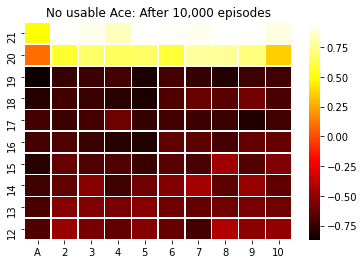

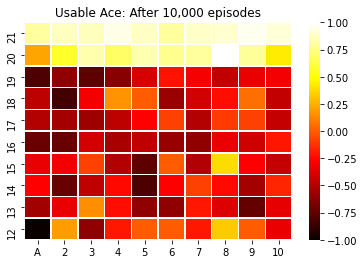

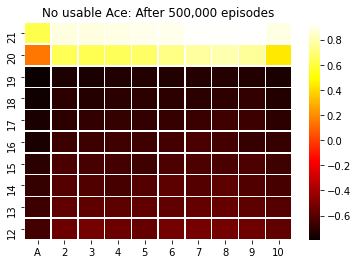

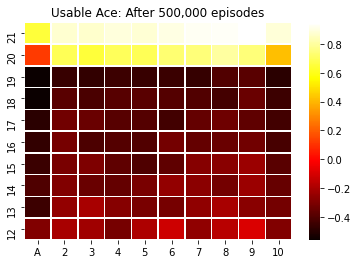

In [21]:
import seaborn as sns

def create_value_map(values): 
    value_map = np.zeros((10,10))
    value_map_ace = np.zeros((10, 10))
    for s in values:
        if not s[2]:
            value_map[s[0]-12, s[1]-1] = values[s]
        else:
            value_map_ace[s[0]-12, s[1]-1] = values[s]
    return np.flipud(value_map), np.flipud(value_map_ace)

        
def plotting(values, title):
    ax = sns.heatmap(values, cmap="hot", linewidth=0.5)
    labels = range(10)
    x_labels = [i+1 for i in labels]
    x_labels[0] = "A"
    y_labels = reversed([i+12 for i in labels])
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.title(title)
    plt.show()

value_map, value_map_ace = create_value_map(V_10k)
value_map_500k, value_map_500k_ace = create_value_map(V_500k)

plotting(value_map, "No usable Ace: After 10,000 episodes")
plotting(value_map_ace, "Usable Ace: After 10,000 episodes")
plotting(value_map_500k, "No usable Ace: After 500,000 episodes")
plotting(value_map_500k_ace, "Usable Ace: After 500,000 episodes")

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [22]:
import random

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    
    def policy_fn(observation):
        rand = random.random()
        if rand > epsilon:
            a = np.argmax(Q[observation])
        else:
            a = random.choice(range(len(Q[observation])))
        return a
    return policy_fn

In [23]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    state_actions = []
    for i in range(num_episodes):
        # Generate episode
        s_next = env.reset()
        done = False
        state_action_reward = []
        while not done: 
            s = s_next
            a = policy(s)
            s_next, r, done, info = env.step(a)
            state_action_reward.append((s, a, r))
            state_actions.append((s, a))
        # update count and sum
        G = 0
        for (s, a, r) in reversed(state_action_reward):
            G = discount_factor * G + r 
            returns_count[s][a] = returns_count[s][a] + 1
            returns_sum[s][a] = returns_sum[s][a] + G
        
    # update final value function
    for (s, a) in state_actions:
        Q[s][a] = returns_sum[s][a]/returns_count[s][a]
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

In [24]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

CPU times: user 31.7 s, sys: 901 ms, total: 32.6 s
Wall time: 31.3 s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

Assuming we will follow a fully greedy policy from now onwards then: $v_{*}(s)=\max _{a} q_{*}(s, a)$
If we follow a $\epsilon$-greedy policy then: $v_{*}(s)=(1-\varepsilon) \max _{a} \widetilde{q}_{*}(s, a)+\frac{\varepsilon}{|\mathcal{A}(s)|} \sum_{a} \widetilde{q}_{*}(s, a)$. Below we will use the greedy policy

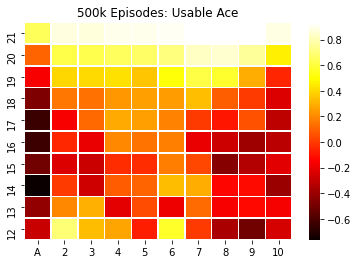

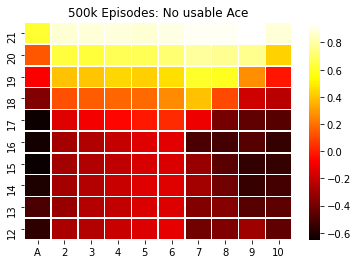

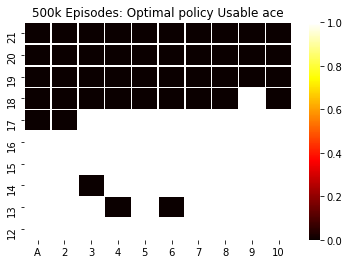

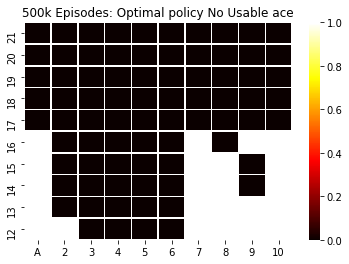

In [25]:
# Plotting Value function
V = defaultdict(float)
for s in Q:
    V[s] = max(Q[s])

values_MC, values_MC_ace = create_value_map(V)
plotting(values_MC_ace, "500k Episodes: Usable Ace")
plotting(values_MC, "500k Episodes: No usable Ace")


# Plotting Greedy policy
opt_pol = defaultdict(int)
for s in Q:
    opt_pol[s] = np.argmax(Q[s])
    
opt_pol_MC, opt_pol_MC_ace = create_value_map(opt_pol)
plotting(opt_pol_MC_ace, "500k Episodes: Optimal policy Usable ace")
plotting(opt_pol_MC, "500k Episodes: Optimal policy No Usable ace")


